# Malária Cells - Residual Networks

https://arxiv.org/pdf/1512.03385.pdf

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import tensorflow.contrib.slim as slim
import random

In [2]:
%matplotlib inline

In [3]:
IMG_SIZE = (110, 110)
COLOR_CHANNELS = 3

### Data Sample

Sample of an uninfected cell image

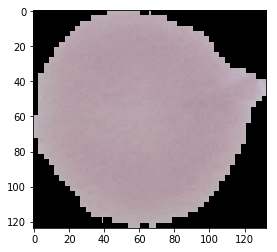

In [4]:
sample_uninfected = cv.imread('/media/miguel/Novo volume/cell_images/Uninfected/C179P140ThinF_IMG_20151127_153521_cell_155.png')
plt.imshow(sample_uninfected)

Sample of an parasitized cell image

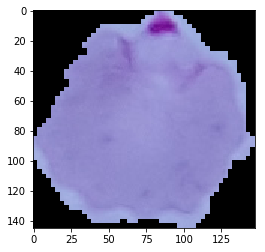

In [5]:
sample_parasitized = cv.imread('/media/miguel/Novo volume/cell_images/Parasitized/C99P60ThinF_IMG_20150918_142334_cell_36.png')
plt.imshow(sample_parasitized)

In [6]:
p_path = '/media/miguel/Novo volume/cell_images/Parasitized'
u_path = '/media/miguel/Novo volume/cell_images/Uninfected'

Load Data

In [7]:
import glob

In [8]:
p_names = glob.glob(p_path+"/*.png")
u_names = glob.glob(u_path+"/*.png")

In [17]:
def load_batch(batch_size):
    batch_x, batch_y = [], []
    for i in range(batch_size):
        if random.choice([True, False]): #Uninfected
            name, label = u_names[random.randrange(len(u_names))], [0]
        else: #Parasitized
            name, label = p_names[random.randrange(len(p_names))], [1]
        batch_x.append(cv.resize(cv.imread(name), IMG_SIZE))
        batch_y.append(label)
    return batch_x, batch_y

In [34]:
#load validation data
test_data, test_labels = [], []

#uninfected
for i in glob.glob('/media/miguel/Novo volume/cell_images/utest/*.png'):
    aux = cv.resize(cv.imread(i), IMG_SIZE)
    test_data.append(aux)
    test_labels.append([0])

#parasitized
for i in glob.glob('/media/miguel/Novo volume/cell_images/ptest/*.png'):
    aux = cv.resize(cv.imread(i), IMG_SIZE)
    test_data.append(aux)
    test_labels.append([1])

## Building the Model

In [35]:
model_input = tf.placeholder(tf.float32, shape=[None, IMG_SIZE[0], IMG_SIZE[0], COLOR_CHANNELS])
labels = tf.placeholder(tf.float32, shape=[None, 1])
learning_rate = tf.placeholder('float', [])

In [36]:
def model(x):
    hl = tf.layers.batch_normalization(x)
    print(hl.shape)
    hl = slim.max_pool2d(hl, [3,3], stride=2)
    print(hl.shape)
    hl = tf.layers.batch_normalization(slim.conv2d(hl, 86, [5,5]))
    print(hl.shape)
    hl = slim.max_pool2d(hl, [3,3], stride=2)
    print(hl.shape)
    hl = tf.layers.batch_normalization(slim.conv2d(hl, 128, [3, 3]))
    print(hl.shape)
    hl = tf.layers.batch_normalization(slim.conv2d(hl, 128, [3, 3]))
    print(hl.shape)
    hl = tf.layers.batch_normalization(slim.conv2d(hl, 86, [3, 3]))
    print(hl.shape)
    hl = slim.max_pool2d(hl, [3,3], stride=2)
    print(hl.shape)
    hl = slim.flatten(hl)
    print(hl.shape)
    hl = tf.nn.sigmoid(slim.stack(hl, slim.fully_connected, [3096, 1569, 564, 84, 1]))
    print(hl.shape)
    
    return hl

In [37]:
prediction = model(model_input)

(?, 110, 110, 3)
(?, 54, 54, 3)
(?, 54, 54, 86)
(?, 26, 26, 86)
(?, 26, 26, 128)
(?, 26, 26, 128)
(?, 26, 26, 86)
(?, 12, 12, 86)
(?, 12384)
(?, 1)


In [38]:
loss = tf.reduce_mean((prediction - labels)**2)
train = tf.train.AdamOptimizer(learning_rate).minimize(loss)

In [45]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [46]:
batch_size = 10
steps = 10000
rate = 3e-5

In [47]:
with tf.Session() as sess:
    sess.run(init)
    for i in range(steps):
        batch_x, batch_y = load_batch(batch_size)
        feed = {model_input:batch_x, labels:batch_y, learning_rate:rate}
        sess.run(train, feed_dict=feed)
        
        if i%10 == 0:
            feed_validation = {model_input:test_data, labels:test_labels}
            print(sess.run(loss, feed_dict=feed_validation))
            
    location = '../saved_models/modelo.ckpt'
    save_path = (saver.save(sess, location))
    print('model saved in', location)

0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5


KeyboardInterrupt: 